In [1]:
import subprocess
import time
subprocess.check_output(["maturin", "develop"])

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
    Finished dev [unoptimized + debuginfo] target(s) in 0.02s
📦 Built wheel for CPython 3.10 to /tmp/.tmpNTUhlM/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


b''

In [2]:
import luthier.luthier
from luthier.luthier import DspGraph, SineOscillator
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import Audio, display, Image, HTML
from luthier import dsp
SAMPLE_RATE = 22050

took 18.71336579322815


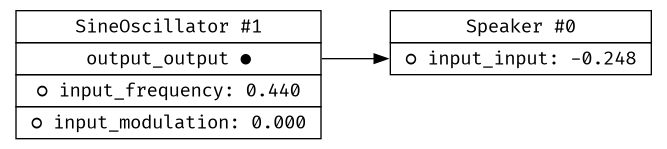

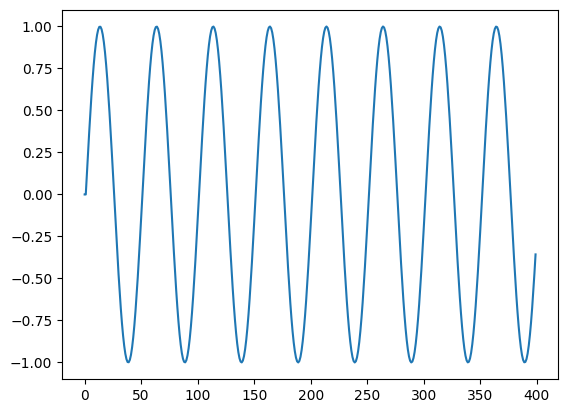

In [3]:
graph = DspGraph()
graph.set_input(1, "input_frequency", 0.440)
time_start = time.time()
result = graph.play(SAMPLE_RATE * 1000)
time_end = time.time()
print("took", time_end - time_start)
display(Image(bytes(graph.draw())))
plt.plot(result[:400])

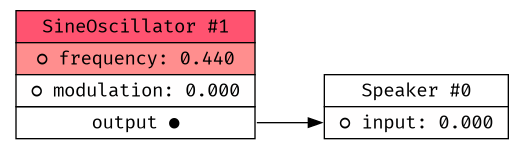

took 43.849515199661255


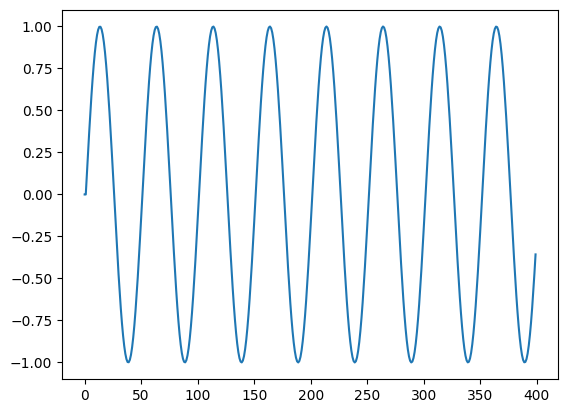

In [4]:
graph = dsp.DspGraph()

sine = dsp.SineOscillator()
sine.inputs.frequency = 0.440

sine = graph.add_node(sine)
graph.patch( sine, "output", graph.speaker, "input" )

display(Image(graph.draw()))
time_start = time.time()
result = graph.play(SAMPLE_RATE * 1000).buffer
time_end = time.time()
print("took", time_end - time_start)
plt.plot(result[:400])